In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score, recall_score, precision_score, brier_score_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.pipeline import Pipeline

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.metrics import classification_report_imbalanced

from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, DiscriminationThreshold, ClassPredictionError, PrecisionRecallCurve
from yellowbrick.model_selection import CVScores

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

import eli5

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)


Bad key "text.kerning_factor" on line 4 in
C:\Users\dutchr01\AppData\Local\Continuum\anaconda3\envs\pycaret\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
df = pd.read_csv(r'D:\Python ML\SA_Geology_protolith_predictions\data\external\classifier_data_2019-02-26_ilr_training.csv',encoding = "ISO-8859-1", engine='python') #training set
df2 = pd.read_csv(r'D:\Python ML\SA_Geology_protolith_predictions\data\external\classifier_data_2019-02-26_ilr_validation.csv',encoding = "ISO-8859-1", engine='python') #validation set

In [69]:
df2.head(2)

,rock_group,rock_type,sample_id,author,title,journal,year,doi,bibtex,sio2,tio2,al2o3,feo_tot,mgo,cao,na2o,k2o,p2o5,index,coord_1,coord_2,coord_3,coord_4,coord_5,coord_6,coord_7,coord_8
0,igneous,granite,59,Liu; X.; Jahn; B. M.; Zhao; Y.; Li; M.; Li; H....,NaN,NaN,NaN,NaN,NaN,73.433815,0.410130,14.487850,0.553676,0.440890,1.722547,3.240029,5.588024,0.123039,59,3.668233,-0.792621,2.26666,1.959484,0.355884,-0.284136,-0.755910,2.930995
1,igneous,granodiorite,68,BAS_GEOLDB,NaN,NaN,NaN,NaN,NaN,68.124936,0.498525,14.314783,2.919931,2.848713,3.916980,4.140808,3.153932,0.081392,68,3.477159,-0.733763,0.85790,0.686613,0.269910,0.176668,0.407657,3.807495


In [3]:
#create raw X training set and binary labeled y array
X_train_raw,y_train = df[['sio2','tio2','al2o3','feo_tot','mgo','cao','na2o','k2o','p2o5']], df[['rock_group']].replace(['igneous','sedimentary'],[0,1])
X_valid_raw, y_valid = df2[['sio2','tio2','al2o3','feo_tot','mgo','cao','na2o','k2o','p2o5']], df2[['rock_group']].replace(['igneous','sedimentary'],[0,1])

#create standard scaled X training and validation set
scaler = StandardScaler().fit(X_train_raw) # zscore standard scale
X_train_scaled = pd.DataFrame(scaler.transform(X_train_raw),columns=['sio2','tio2','al2o3','feo_tot','mgo','cao','na2o','k2o','p2o5'])
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid_raw),columns=['sio2','tio2','al2o3','feo_tot','mgo','cao','na2o','k2o','p2o5'])

print('Training data')
print(X_train_raw.shape)
print(X_train_scaled.shape)
print(y_train.shape)
print('\n')
print('Validation data')
print(X_valid_raw.shape)
print(X_valid_scaled.shape)
print(y_valid.shape)


Training data
(480024, 9)
(480024, 9)
(480024, 1)


Validation data
(53336, 9)
(53336, 9)
(53336, 1)


In [10]:
# tune BalancedRandomForrest hyperparamaters and asses validation set with grid search based on best random search params

# Set the parameters by cross-validation
n_estimators = [int(x) for x in np.linspace(start=800, stop=1400,num=7)]
max_features = ['sqrt']
max_depth = [int(x) for x in np.linspace(30, 90, num=7)]
max_depth.append(None)
min_samples_split = [1,2,3]
min_samples_leaf = [1]

cv = StratifiedKFold(n_splits=5, random_state=101)

parameters = {'brfc__n_estimators': n_estimators, 'brfc__max_features': max_features,
                     'brfc__max_depth': max_depth, 'brfc__min_samples_split': min_samples_split,
                    'brfc__min_samples_leaf': min_samples_leaf, 'brfc__random_state': [101]}

scores = ['recall_macro']

pipe = Pipeline([('sc', StandardScaler()),
                ('brfc', BalancedRandomForestClassifier())])

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        estimator= pipe, param_grid= parameters, scoring='%s' % score, n_jobs = 3, cv= cv, verbose = 1
    )
    clf.fit(X_train_raw, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_valid, clf.predict(X_valid_raw)
    print(classification_report(y_true, y_pred))
    print()
    print(confusion_matrix(y_true, y_pred))
    print()

epth': 60, 'brfc__max_features': 'sqrt', 'brfc__min_samples_leaf': 1, 'brfc__min_samples_split': 1, 'brfc__n_estimators': 900, 'brfc__random_state': 101}
nan (+/-nan) for {'brfc__max_depth': 60, 'brfc__max_features': 'sqrt', 'brfc__min_samples_leaf': 1, 'brfc__min_samples_split': 1, 'brfc__n_estimators': 1000, 'brfc__random_state': 101}
nan (+/-nan) for {'brfc__max_depth': 60, 'brfc__max_features': 'sqrt', 'brfc__min_samples_leaf': 1, 'brfc__min_samples_split': 1, 'brfc__n_estimators': 1100, 'brfc__random_state': 101}
nan (+/-nan) for {'brfc__max_depth': 60, 'brfc__max_features': 'sqrt', 'brfc__min_samples_leaf': 1, 'brfc__min_samples_split': 1, 'brfc__n_estimators': 1200, 'brfc__random_state': 101}
nan (+/-nan) for {'brfc__max_depth': 60, 'brfc__max_features': 'sqrt', 'brfc__min_samples_leaf': 1, 'brfc__min_samples_split': 1, 'brfc__n_estimators': 1300, 'brfc__random_state': 101}
nan (+/-nan) for {'brfc__max_depth': 60, 'brfc__max_features': 'sqrt', 'brfc__min_samples_leaf': 1, 'brfc_

In [11]:
(clf.best_params_)

{'brfc__max_depth': 50,
 'brfc__max_features': 'sqrt',
 'brfc__min_samples_leaf': 1,
 'brfc__min_samples_split': 2,
 'brfc__n_estimators': 1000,
 'brfc__random_state': 101}

In [20]:
brf_clf_tuned_pipe = clf.best_estimator_

In [21]:
brf_clf_tuned_pipe.steps

[('sc', StandardScaler()),
 ('brfc',
  BalancedRandomForestClassifier(max_depth=50, max_features='sqrt',
                                 min_samples_leaf=1, n_estimators=1000,
                                 random_state=101))]

In [25]:
feature_importance = eli5.explain_weights_df(brf_clf_tuned_pipe.named_steps['brfc'], feature_names=list(X_train_raw.columns) )
feature_importance

,feature,weight,std
0,na2o,0.203987,0.063161
1,cao,0.176764,0.050724
2,mgo,0.124217,0.040592
3,feo_tot,0.104823,0.047944
4,al2o3,0.089809,0.038124
5,sio2,0.086024,0.038014
6,k2o,0.081700,0.015679
7,tio2,0.077829,0.035545
8,p2o5,0.054847,0.009172


In [26]:
joblib.dump(brf_clf_tuned_pipe, 'brf_clf_tuned_pipe_20200602.joblib')

['brf_clf_tuned_pipe_20200602.joblib']

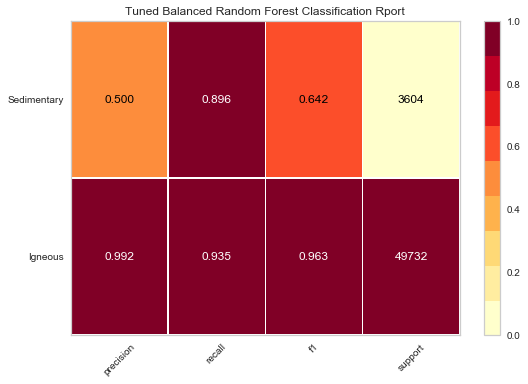

In [47]:
vis = ClassificationReport(brf_clf_tuned_pipe, classes=['Igneous','Sedimentary'],support=True, is_fitted=True, title='Tuned Balanced Random Forest Classification Rport')
vis.fit(X_train_raw,y_train)
vis.score(X_valid_raw,y_valid)
vis.show(outpath=r'D:\Python ML\SA_Geology_protolith_predictions\reports\figures\tuned_BRF_class_report.png')

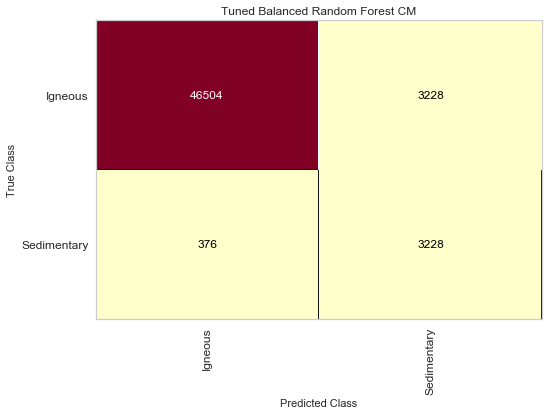

In [46]:
cm = ConfusionMatrix(brf_clf_tuned_pipe,classes=['Igneous','Sedimentary'],is_fitted=True, title='Tuned Balanced Random Forest CM')
cm.fit(X_train_raw,y_train)
cm.score(X_valid_raw,y_valid)
cm.show(outpath=r'D:\Python ML\SA_Geology_protolith_predictions\reports\figures\tuned_BRF_CM.png')

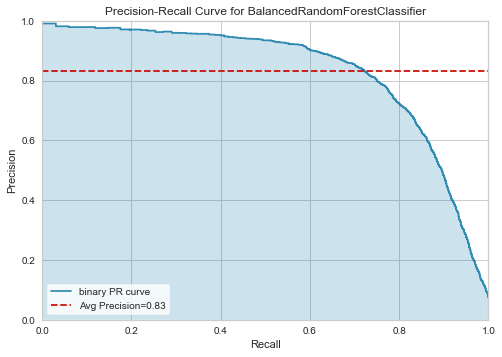

In [36]:
pr = PrecisionRecallCurve(brf_clf_tuned_pipe,per_class= True, classes=['Igneous','Sedimentary'],is_fitted=True)
pr.fit(X_train_raw,y_train)
pr.score(X_valid_raw,y_valid)
pr.show()

In [5]:
brf_clf_tuned_pipe = joblib.load(r'D:\Python ML\SA_Geology_protolith_predictions\models\brf_clf_tuned_cal_pipe_20200611.joblib')

In [15]:
brf_clf_tuned_pipe.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('sc', StandardScaler()),
                ('brfc',
                 BalancedRandomForestClassifier(max_depth=50,
                                                max_features='sqrt',
                                                min_samples_leaf=1,
                                                n_estimators=1000,
                                                random_state=101))])>

In [20]:
test_probability

array([[0.91246667, 0.08753333],
       [0.545     , 0.455     ],
       [0.991     , 0.009     ],
       ...,
       [0.962     , 0.038     ],
       [0.786     , 0.214     ],
       [0.942     , 0.058     ]])

In [39]:
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(brf_clf_tuned_pipe, cv='prefit', method='isotonic').fit(X_train_raw,y_train)

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(brf_clf_tuned_pipe, cv='prefit', method='sigmoid').fit(X_train_raw,y_train)

In [77]:
def plot_calibration_curve(est, iso, sig, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(est, name),
                      (iso, name + ' + Isotonic'),
                      (sig, name + ' + Sigmoid')]:
        #clf.fit(X_train, y_train)
        y_pred = clf.predict(X_valid_raw)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_valid_raw)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_valid_raw)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_valid, prob_pos)#, pos_label=y_train.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_valid, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_valid, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_valid, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_valid, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()
    plt.savefig(r'D:\Python ML\SA_Geology_protolith_predictions\reports\figures\Calibration_curve.png')

BalancedRandomForest_Sedimentary:
	Brier: 0.057
	Precision: 0.500
	Recall: 0.896
	F1: 0.642

BalancedRandomForest_Sedimentary + Isotonic:
	Brier: 0.023
	Precision: 0.867
	Recall: 0.676
	F1: 0.760

BalancedRandomForest_Sedimentary + Sigmoid:
	Brier: 0.024
	Precision: 0.784
	Recall: 0.766
	F1: 0.775



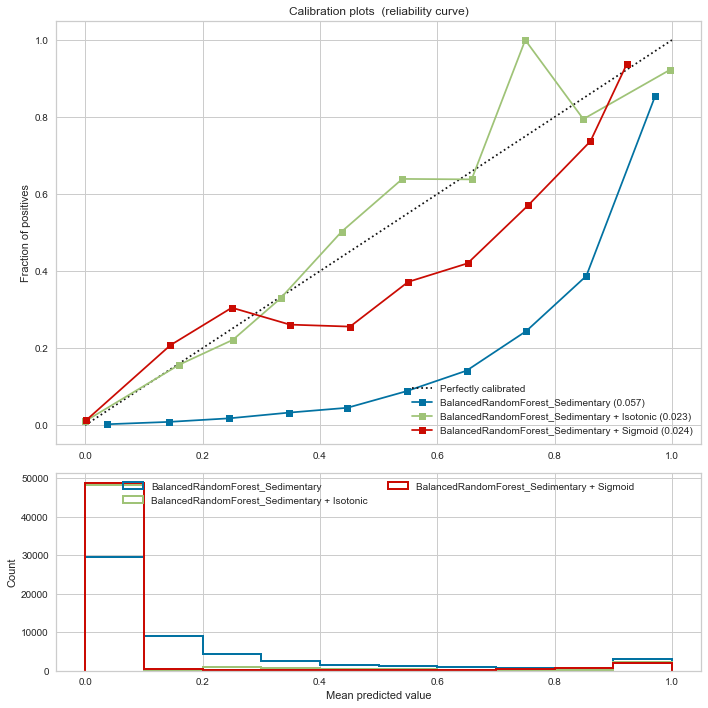

In [78]:
plot_calibration_curve(brf_clf_tuned_pipe, isotonic, sigmoid, "BalancedRandomForest_Sedimentary", 1)

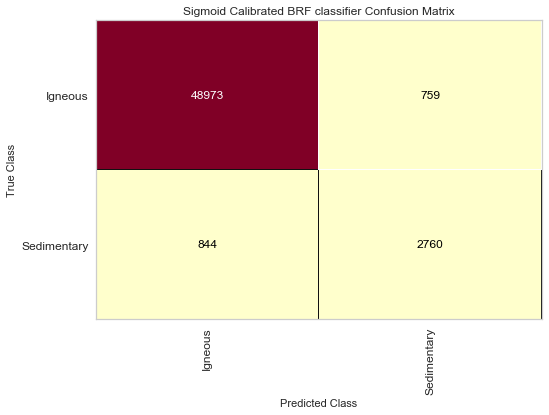

In [44]:
cm = ConfusionMatrix(sigmoid,classes=['Igneous','Sedimentary'],is_fitted=True, title = 'Sigmoid Calibrated BRF classifier Confusion Matrix')
cm.fit(X_train_raw,y_train)
cm.score(X_valid_raw,y_valid)
cm.show(outpath=r'D:\Python ML\SA_Geology_protolith_predictions\reports\figures\sigmoid_Cal_BRF_CM.png')

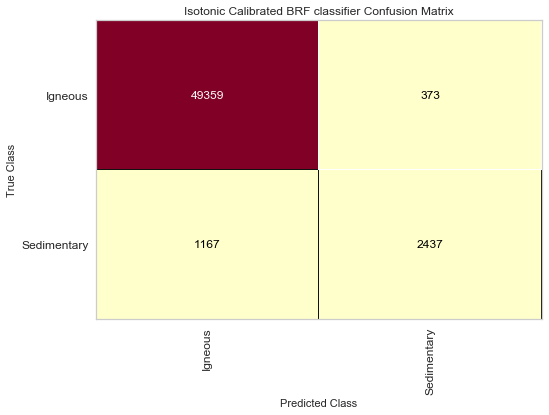

In [45]:
cm = ConfusionMatrix(isotonic,classes=['Igneous','Sedimentary'],is_fitted=True, title = 'Isotonic Calibrated BRF classifier Confusion Matrix')
cm.fit(X_train_raw,y_train)
cm.score(X_valid_raw,y_valid)
cm.show(outpath=r'D:\Python ML\SA_Geology_protolith_predictions\reports\figures\isotonic_Cal_BRF_CM.png')

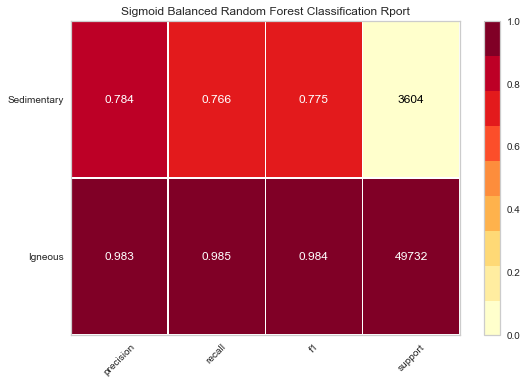

In [48]:
vis = ClassificationReport(sigmoid, classes=['Igneous','Sedimentary'],support=True, is_fitted=True, title='Sigmoid Balanced Random Forest Classification Rport')
vis.fit(X_train_raw,y_train)
vis.score(X_valid_raw,y_valid)
vis.show(outpath=r'D:\Python ML\SA_Geology_protolith_predictions\reports\figures\tuned_claibrated_BRF_class_report.png')

In [49]:
sigmoid

CalibratedClassifierCV(base_estimator=Pipeline(steps=[('sc', StandardScaler()),
                                                      ('brfc',
                                                       BalancedRandomForestClassifier(max_depth=50,
                                                                                      max_features='sqrt',
                                                                                      min_samples_leaf=1,
                                                                                      n_estimators=1000,
                                                                                      random_state=101))]),
                       cv='prefit')

In [51]:
joblib.dump(sigmoid, r'D:\Python ML\SA_Geology_protolith_predictions\models\brf_clf_tuned_cal_pipe_20200611.joblib')

['D:\\Python ML\\SA_Geology_protolith_predictions\\models\\brf_clf_tuned_cal_pipe_20200611.joblib']

In [7]:
test_predictions = pd.DataFrame(brf_clf_tuned_pipe.predict(X_valid_raw))
test_probability = pd.DataFrame(brf_clf_tuned_pipe.predict_proba(X_valid_raw))
#test_predictions_cal = pd.DataFrame(sigmoid.predict(X_valid_raw))
#test_probability_cal = pd.DataFrame(sigmoid.predict_proba(X_valid_raw))

In [11]:
test_probability.head()

,0
0,0
1,0
2,0
3,1
4,0


In [64]:

validation_predictions = pd.concat([df2[['rock_group','rock_type']],y_valid, test_predictions, test_probability, test_predictions_cal, test_probability_cal],axis=1) 
validation_predictions.columns = ['rock_group', 'rock_type', 'true_label', 'predicted_label','proba_0', 'proba_1','cal_predict_label', 'cal_proba_0', 'cal_proba_1'] 


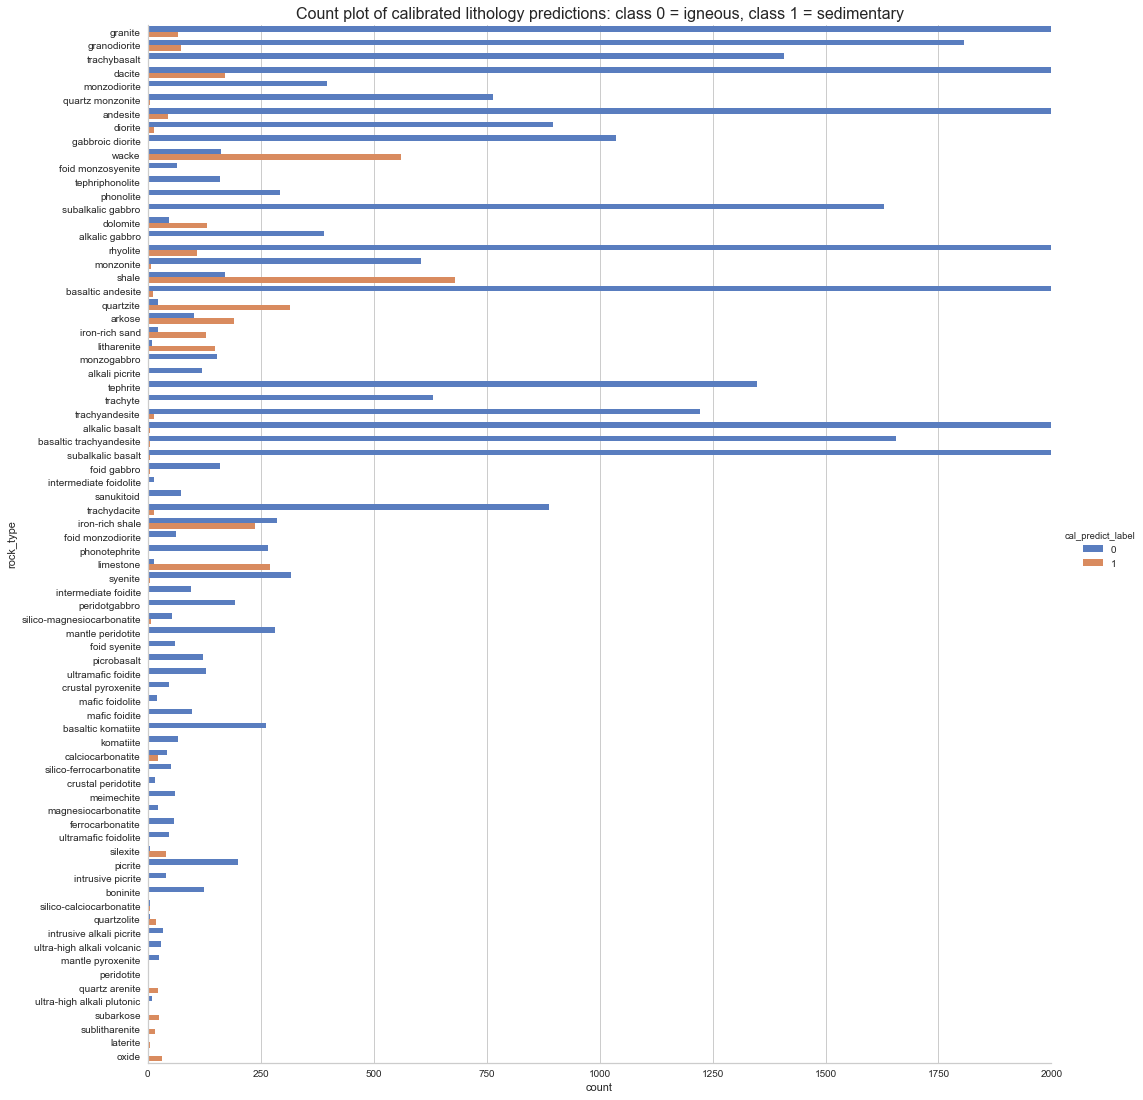

In [101]:
sns.catplot(hue='cal_predict_label',y= 'rock_type', data=validation_predictions, height = 15,kind='count',palette='muted')
plt.xlim(0,2000)
plt.title('Count plot of calibrated lithology predictions: class 0 = igneous, class 1 = sedimentary', fontsize=16)
plt.show
plt.savefig(r'D:\Python ML\SA_Geology_protolith_predictions\reports\figures\Validation_set_predictions_by_lith.png')

In [90]:
cal_incorrect = validation_predictions.query('true_label != predicted_label & predicted_label == cal_predict_label')
cal_incorrect

,rock_group,rock_type,true_label,predicted_label,proba_0,proba_1,cal_predict_label,cal_proba_0,cal_proba_1
3,igneous,dacite,0,1,0.137500,0.862500,1,0.390055,0.609945
31,igneous,NaN,0,1,0.145667,0.854333,1,0.421977,0.578023
228,sedimentary,iron-rich shale,1,0,0.756450,0.243550,0,0.999932,0.000068
478,igneous,NaN,0,1,0.012000,0.988000,1,0.077130,0.922870
510,igneous,NaN,0,1,0.090000,0.910000,1,0.228417,0.771583
...,...,...,...,...,...,...,...,...,...
53062,igneous,trachydacite,0,1,0.136000,0.864000,1,0.384284,0.615716
53064,igneous,silexite,0,1,0.006000,0.994000,1,0.070483,0.929517
53093,igneous,granite,0,1,0.119250,0.880750,1,0.322350,0.677650
53106,igneous,granodiorite,0,1,0.067000,0.933000,1,0.169355,0.830645


In [107]:
cal_correct = validation_predictions.query('true_label != predicted_label & true_label == cal_predict_label')
cal_correct

,rock_group,rock_type,true_label,predicted_label,proba_0,proba_1,cal_predict_label,cal_proba_0,cal_proba_1
9,igneous,NaN,0,1,0.433000,0.567000,0,0.987186,0.012814
64,igneous,NaN,0,1,0.489250,0.510750,0,0.994813,0.005187
117,igneous,granite,0,1,0.465000,0.535000,0,0.992333,0.007667
156,igneous,quartz monzonite,0,1,0.418250,0.581750,0,0.983780,0.016220
159,igneous,quartz monzonite,0,1,0.422133,0.577867,0,0.984754,0.015246
...,...,...,...,...,...,...,...,...,...
53315,igneous,dacite,0,1,0.238500,0.761500,0,0.766845,0.233155
53316,igneous,dacite,0,1,0.393167,0.606833,0,0.975836,0.024164
53317,igneous,dacite,0,1,0.340000,0.660000,0,0.944609,0.055391
53325,igneous,quartzolite,0,1,0.442000,0.558000,0,0.988906,0.011094


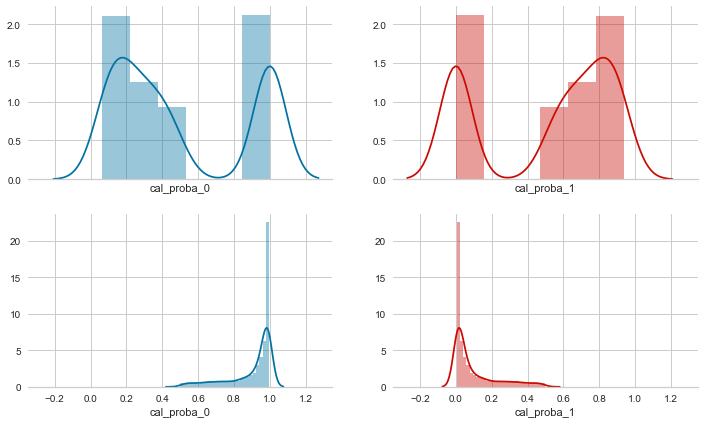

In [106]:
f, axes = plt.subplots(2, 2, figsize=(12, 7), sharex=True,)
sns.despine(left=True)

sns.distplot(cal_incorrect['cal_proba_0'], color='b',ax=axes[0,0])
sns.distplot(cal_incorrect['cal_proba_1'], color='r',ax=axes[0,1])
sns.distplot(cal_correct['cal_proba_0'], color='b',ax=axes[1,0])
sns.distplot(cal_correct['cal_proba_1'], color='r',ax=axes[1,1])